In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#initialize dataframes
df = pd.read_csv('General_Sedan.csv', index_col=0)
df.head()

,date,message,time,username
0,2002-03-23,Entry level performance luxury sedans are a ho...,19:04:32,cybersol
1,2002-03-25,I personally think that with a few tweaks the ...,05:54:02,merc1
2,2002-03-25,I am debating a new purchase and these two are...,07:06:29,fredvh
3,2002-03-25,"Great handling, RWD, excellent engine and the ...",17:02:27,blueguydotcom
4,2002-03-25,And no manual tranny. That may not matter to ...,23:04:37,hungrywhale


In [3]:
#initialize brand data, remove weird values

model_df = pd.read_csv('Cars make model list.csv', encoding='utf-8', names=['brand', 'model'])
model_df['brand'] = model_df['brand'].str.lower()
model_df['model'] = model_df['model'].str.lower()

model_dict = model_df.set_index('model')['brand'].to_dict()
model_df.head()

,brand,model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx


In [4]:
# Define function to remove unnecessary characters from words
from nltk import pos_tag, word_tokenize
def remove_weird_char(string):
    import re
    string = string.lower()
    words = string.split()
    refined = []
    for i in words:
        refined.append(re.sub("[^\w]+", " ", i))
    sentence = ' '.join([word for word in refined])
    return(sentence)

#define function to replace brand references with model references
def replace_brand(text):
    aset = set(text.split())
    overlap = aset.intersection(set(model_dict.keys()))
    aset = (aset-overlap).union(set([model_dict[x] for x in overlap]))
    return ' '.join([word for word in aset])

# Define function to remove stopwords from given text
# also removes duplicate words in a single message
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
def rmStopWords(text):
        text = ' '.join([word for word in set(text.split()) if word not in cachedStopWords])
        return text
    
#define function to replace some punctuation with spaces
def rep_punct(text):
    return text.lower().replace('.',' ').replace('!',' ').replace(',',' ').replace('?',' ').replace(')',' ').replace('(',' ')

# Define function to remove unnecessary characters from words
from nltk import pos_tag, word_tokenize
def remove_weird_char(string):
    import re
    string = string.lower()
    words = string.split()
    refined = []
    for i in words:
        refined.append(re.sub("[^\w]+", " ", i))
    sentence = ' '.join([word for word in refined])
    return(sentence)

In [5]:
# process comments with above functions

df['fixedmessage'] = df['message'].apply(rep_punct).apply(replace_brand).apply(rmStopWords).apply(remove_weird_char)

In [6]:
# Slice dataframe to get relevant column
messages = df['fixedmessage'].str.cat(sep=" ")

# Tokenize, tag, and turn into a dataframe
pos_df = pd.DataFrame(pos_tag(word_tokenize(messages)), columns = ['Word', 'POS'])

In [7]:
# top brands by number of mentions (by message)
brands = set(model_dict.values())
relevant_brands = brands-{'car','seat','sedan','problem'}

top_10_brands = pos_df[pos_df['Word'].isin(relevant_brands)]['Word'].value_counts()[:10].index
pos_df[pos_df['Word'].isin(brands)]['Word'].value_counts()[:10]

car         5083
bmw         3887
sedan       3588
audi        2392
infiniti    2392
acura       1495
cadillac     897
toyota       897
mercedes     897
chrysler     598
Name: Word, dtype: int64

# Task A

In [8]:
#calculate lift values

def calc_lift(a, b):
    total_size = len(df)
    filter_a = df[df['fixedmessage'].str.contains(a)]
    num_a = len(filter_a)
    num_b = len(df[df['fixedmessage'].str.contains(b)])
    num_a_b = len(filter_a['fixedmessage'][filter_a['fixedmessage'].str.contains(b)])
    if num_a_b==0:
        return .2
    return round(total_size*float(num_a_b)/float(num_a*num_b),2)

In [9]:
#function to uniquely combine relevant brands
def permute(aset):
    alist = []
    for item1 in aset:
        for item2 in aset-{item1}:
            newset = {item1, item2}
            if newset not in alist:
                alist.append(newset)
    
    return alist

In [10]:
# make dataframe of lift values
aset = list(top_10_brands)
test_df = pd.DataFrame(columns=aset, index=aset)

for brand1, series in list(test_df.iterrows()):
    for brand2 in series.index:
        test_df[brand2].loc[brand1] = calc_lift(brand1, brand2)

test_df

,bmw,infiniti,audi,acura,toyota,mercedes,cadillac,buick,chrysler,volvo
bmw,2.82,1.76,2.01,1.69,0.94,2.82,2.82,1.41,2.82,2.82
infiniti,1.76,3.88,1.66,1.55,0.2,1.94,2.58,0.2,1.94,3.88
audi,2.01,1.66,4.43,2.66,1.48,4.43,2.95,2.21,4.43,4.43
acura,1.69,1.55,2.66,6.2,2.07,6.2,2.07,3.1,6.2,6.2
toyota,0.94,0.2,1.48,2.07,10.33,5.17,0.2,5.17,5.17,0.2
mercedes,2.82,1.94,4.43,6.2,5.17,15.5,5.17,7.75,15.5,15.5
cadillac,2.82,2.58,2.95,2.07,0.2,5.17,10.33,0.2,5.17,10.33
buick,1.41,0.2,2.21,3.1,5.17,7.75,0.2,15.5,7.75,0.2
chrysler,2.82,1.94,4.43,6.2,5.17,15.5,5.17,7.75,15.5,15.5
volvo,2.82,3.88,4.43,6.2,0.2,15.5,10.33,0.2,15.5,31


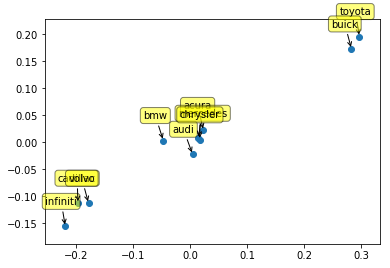

In [11]:
#make dissimilarity matrix and plot
dissimilarity = 1/test_df

import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

adist = np.array(dissimilarity)
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(dissimilarity.columns.values, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=.3', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

# Task B
Something

# Task C

In [12]:
#find most frequent words which aren't brands, then inspect visually

mask = pos_df['Word'].str.len()>2
mask2 = ~pos_df['Word'].isin(brands)

pos_df[mask&mask2]['Word'].value_counts()[:20]

manual         4186
drive          4186
performance    3588
g35            3588
don            3289
get            2990
lexus          2691
think          2392
luxury         2392
one            2392
even           2392
great          2093
price          2093
would          2093
never          1794
new            1794
buy            1794
handling       1794
automatic      1794
es300          1794
Name: Word, dtype: int64

In [13]:
top_5_attributes = ['manual', 'performance', 'luxury', 'price', 'handling']
top_5_brands = pos_df[pos_df['Word'].isin(relevant_brands)]['Word'].value_counts()[:5].index

In [14]:
attribute_df = pd.DataFrame(columns=top_5_brands, index=top_5_attributes)

for attribute, series in list(attribute_df.iterrows()):
    for brand in series.index:
        attribute_df[brand].loc[attribute] = calc_lift(brand, attribute)
        
attribute_df

,bmw,infiniti,audi,acura,toyota
manual,1.41,1.11,0.63,0.44,0.2
performance,1.64,0.97,1.48,1.55,0.86
luxury,1.76,1.45,2.21,2.33,1.29
price,1.61,1.66,1.9,3.54,2.95
handling,2.25,1.55,3.54,3.72,2.07


In [15]:
attribute_df.idxmax(axis=0)

bmw         handling
infiniti       price
audi        handling
acura       handling
toyota         price
dtype: object

BMW is most associated with handling in the Edmunds messages, however they cannot claim to be the 'ultimate driving machine' as Audi's handling lift score is higher than BMW's, implying those on Edmunds.com are more likely to talk about Audi and handling than BMW and handling.